In [163]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import warnings
from scipy.optimize import minimize
import scipy.special as sp
from scipy.stats import gamma as gamma_dist

# Disable all warnings
warnings.filterwarnings('ignore')

# Disable specific package warnings if needed
np.seterr(all='ignore')  # Numpy warnings
pd.options.mode.chained_assignment = None  # Pandas warnings

rng = np.random.default_rng()   

### Loads Data

In [164]:
df = pd.read_parquet('s3://moneygans-data/basketball_nba/starting_money/starting_money_agg/starting_money_all.parquet', engine='pyarrow')[['pos_money','neg_money']]
df.head()

,pos_money,neg_money
0,380,-500
1,340,-500
2,400,-550
3,400,-550
4,400,-525


### Adds Cluster Column

In [165]:
def assign_cluster(row):
    """We assign a given observation to cluster 1 if pos_money < 0,
    else we assign to cluster 2"""
    if row['pos_money'] < 0:
        return 1
    else:
        return 2

# Apply the function row-wise
df['cluster'] = df.apply(assign_cluster, axis=1)
df.head()

,pos_money,neg_money,cluster
0,380,-500,2
1,340,-500,2
2,400,-550,2
3,400,-550,2
4,400,-525,2


### Empirical Starting Moneyline Distribution

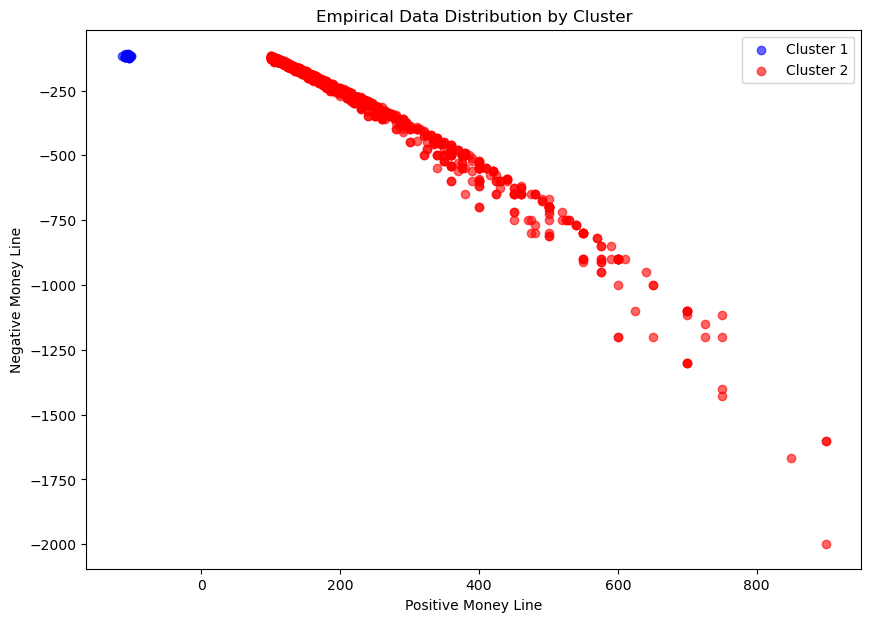

In [166]:
plt.figure(figsize=(10, 7))
for cluster, group in df.groupby('cluster'):
    if cluster == 1:
        color = 'blue'
        label = 'Cluster 1'
    else:
        color = 'red'
        label = 'Cluster 2'
    plt.scatter(group['pos_money'], group['neg_money'], label=label, color=color, alpha=0.6)
plt.title('Empirical Data Distribution by Cluster')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()


# Classical Generative Model

1. Calculate p for falling in Cluster 1 (Gaussian) or Cluster 2 (Linear)
2. Generate Bernoulli(p)
3. If Cluster 1:
    * Sample from bivariate gaussian with mean and cov equal to the empirical metrics
4. If Cluster 2:
    * Use beta dist to sample pos_moneyline (find MLE estimate for params given the data)
    * Fit least squares model 1 for residuals (models heteroscedasticity
    * Fit least squares model 2 to data
    * Add residuals to generated y value when sampling

In [167]:
# Define the negative log-likelihood (NLL) for the Gamma distribution.
def gamma_NLL(k, data):
    # k comes as an array from minimize, so extract the scalar.
    k = k[0]
    # Return infinity if k is not positive (to enforce k > 0)
    if k <= 0:
        return np.inf
    
    n = len(data)
    x_bar = np.mean(data)
    # Scale parameter theta is defined as mean(x) / k
    theta = x_bar / k
    
    # Gamma log-likelihood:
    #   L(k,theta) = (k - 1) * sum(log(data)) - sum(data)/theta - n*k*log(theta) - n*log(Gamma(k))
    # Negative log-likelihood (we want to minimize it):
    nll = -((k - 1) * np.sum(np.log(data)) 
            - (np.sum(data) / theta) 
            - n * k * np.log(theta) 
            - n * sp.gammaln(k))
    return nll

def gaussian_neg_log_likelihood(params, x, y):
    """
    Calculate the negative log likelihood for the model:
      Y | X ~ N( b0 + b1*x + b2*x^2, exp(alpha0 + alpha1*x) )
    
    Parameters:
      params : array-like, [b0, b1, b2, alpha0, alpha1]
      x      : predictor values (numpy array)
      y      : response values (numpy array)
      
    Returns:
      nll : negative log likelihood value (float)
    """
    b0, b1, b2, alpha0, alpha1 = params
    # Mean function: mu = b0 + b1*x + b2*x^2
    mu = b0 + b1 * x + b2 * x**2
    # Variance function: sigma^2 = exp(alpha0 + alpha1*x)
    sigma2 = np.exp(alpha0 + alpha1 * x)
    # Calculate the negative log likelihood
    nll = 0.5 * np.sum(np.log(2 * np.pi) + (alpha0 + alpha1 * x) + ((y - mu)**2) / sigma2)
    return nll

In [168]:
class StatGenModel:
    """
    A statistical model that generates parameters based on empirical data.
    
    Attributes:
        emp_data (pd.DataFrame): The original data.
        c1_data (np.ndarray): Numpy array of data for cluster 1.
        c2_data (np.ndarray): Numpy array of data for cluster 2.
        c1_params (dict): Dictionary containing parameters (mean and covariance) for cluster 1.
    """
    
    def __init__(self):
        """
        Initialize the StatGenModel with a DataFrame containing a 'cluster' column.
        """
        self.emp_data = None
        self.c1_prob = None
        self.c1_data = None
        self.c2_data = None
        self.c1_params = None
        self.c2_params = None

    def fit(self, data):
        # Ensure that the 'cluster' column exists
        if 'cluster' not in data.columns:
            raise ValueError("Data must contain a 'cluster' column.")
     
        self.emp_data = data
        self.c1_data = data[data['cluster'] == 1].drop(['cluster'], axis=1).to_numpy()
        self.c2_data = data[data['cluster'] == 2].drop(['cluster'], axis=1).to_numpy()
        self.c1_prob = self.c1_data.shape[0] / self.emp_data.shape[0] #probability of falling into cluster 1 (cluster 2 is 1-c1_prob)
        self.c1_params = self.fit_c1_params()
        self.c2_params = self.fit_c2_params()
    
    
    def fit_c1_params(self):
        """
        Calculate the mean and covariance matrix for cluster 1 data.
        Returns:
            dict: A dictionary with keys 'mu' and 'sigma'.
        """
        mu = self.c1_data.mean(axis=0)
        sigma = np.cov(self.c1_data, rowvar=False)
        return {'mu': mu, 'sigma': sigma}

    def fit_c2_params(self):
        # Initial guess for parameters [b0, b1, b2, alpha0, alpha1]
        init_params = np.array([0.0, 0.0, 0.0, 0.0, 0.0])
        
        # Minimize the negative log likelihood using scipy.optimize.minimize
        result = minimize(gaussian_neg_log_likelihood, init_params, args=(self.c2_data[:, 0], self.c2_data[:, 1]), method='L-BFGS-B')

        if result.success:
            est_params = result.x
        else:
            raise RuntimeError("Optimization failed:", result.message)
        
        gamma_params = self.fit_c2_gamma_MLEs()

        return {'gamma_shape': gamma_params['shape'], 'gamma_scale': gamma_params['scale'],'b0': est_params[0], 'b1': est_params[1], 'b2': est_params[2], 'a0': est_params[3], 'a1': est_params[4]} #Place holder for data params

    
    def fit_c2_gamma_MLEs(self):
        # Initial guess for k using the method of moments
        gamma_data = self.c2_data[:, 0]
        k_init_moment = (np.mean(gamma_data) ** 2) / np.var(gamma_data, ddof=1)
        
        # Optimize the negative log-likelihood
        result = minimize(
            fun=gamma_NLL, 
            x0=[k_init_moment], 
            args=(gamma_data,), 
            method="L-BFGS-B", 
            bounds=[(0.01, None)]
        )
    
        # Extract the estimated shape parameter k
        k_mle = result.x[0]
        # Compute the scale parameter theta (theta = mean / k)
        theta_mle = np.mean(gamma_data) / k_mle
        
        return {'shape': k_mle, 'scale': theta_mle}

    def plot_clusters(self):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
        
        # Plot Cluster 1 on the first axis
        ax1.scatter(self.c1_data[:, 0], self.c1_data[:, 1], color='blue', alpha=0.7)
        ax1.set_title("Scatter Plot of Cluster 1")
        ax1.set_xlabel("Positive Moneyline")
        ax1.set_ylabel("Negative Moneyline")
        
        # Plot Cluster 2 on the second axis
        ax2.scatter(self.c2_data[:, 0], self.c2_data[:, 1], color='red', alpha=0.7)
        ax2.set_title("Scatter Plot of Cluster 2")
        ax2.set_xlabel("Positive Moneyline")
        ax2.set_ylabel("Negative Moneyline")
        
        plt.tight_layout()
        plt.show()
    
    def plot_gamma(self):
        # Plotting: histogram of data with fitted Gamma PDF overlaid.
        gamma_data = self.c2_data[:, 0]
        plt.figure(figsize=(10, 7))

        # Plot a histogram of the data with density normalization
        count, bins, _ = plt.hist(gamma_data, bins=30, density=True, alpha=0.6, color='g', label='Cluster 2 Data Histogram')

        # Generate x-values for plotting the gamma PDF
        x_values = np.linspace(gamma_data.min(), gamma_data.max(), 100)
        pdf_values = gamma_dist.pdf(x_values, a=self.c2_params['gamma_shape'], scale=self.c2_params['gamma_scale'])

        # Overlay the fitted Gamma PDF
        plt.plot(x_values, pdf_values, 'r-', lw=2, label='Fitted Gamma PDF')

        plt.title("Fitted Gamma Distribution")
        plt.xlabel("Data")
        plt.ylabel("Density")
        plt.legend()
        plt.show()

    def plot_c2_model(self):
        x = self.c2_data[:, 0]
        y = self.c2_data[:, 1]
        
        b0, b1, b2 = self.c2_params['b0'], self.c2_params['b1'], self.c2_params['b2']  
        alpha0, alpha1 = self.c2_params['a0'], self.c2_params['a1']  
        # Create a grid of x values for plotting the fitted curve
        x_grid = np.linspace(np.min(x), np.max(x), 300)
        # Calculate the mean predictions using the quadratic model
        mu_grid = b0 + b1 * x_grid + b2 * x_grid**2
        # Calculate the standard deviation predictions
        sigma_grid = np.sqrt(np.exp(alpha0 + alpha1 * x_grid))

        # Create the plot
        plt.figure(figsize=(8, 6))
        plt.scatter(x, y, label='Data', color='blue', alpha=0.6)
        plt.plot(x_grid, mu_grid, label='Fitted Mean', color='red', linewidth=2)
        # Shade the region within one standard deviation
        plt.fill_between(x_grid, mu_grid - sigma_grid, mu_grid + sigma_grid,
                        color='red', alpha=0.2, label='±1 Std. Dev.')

        plt.xlabel('X')
        plt.ylabel('Y')
        plt.title('Fitted Model with Heteroscedasticity')
        plt.legend()
        plt.show()
    

    def generate(self, size = 1000):
        generated_data = np.zeros(shape=(size,2))
        for i in range(size):
            cluster = np.random.binomial(n=1, p=.5) + 1
            if cluster == 1:
                generated_data[i] = self.generate_c1()
            else:
                generated_data[i] = self.generate_c2()
        return generated_data


    def generate_c1(self, size = 1):
        return rng.multivariate_normal(self.c1_params['mu'], self.c1_params['sigma'], size=size)
    
    def generate_c2(self, size = 1):
        b0, b1, b2 = self.c2_params['b0'], self.c2_params['b1'], self.c2_params['b2']  
        alpha0, alpha1 = self.c2_params['a0'], self.c2_params['a1']  

        # Generate a grid of x values (same range as your data)
        x_sim = np.random.gamma(self.c2_params['gamma_shape'], self.c2_params['gamma_scale'], size=size)

        # Calculate the mean and standard deviation for the simulated points
        mu_sim = b0 + b1 * x_sim + b2 * x_sim**2
        sigma_sim = np.sqrt(np.exp(alpha0 + alpha1 * x_sim))

        # Generate simulated y values from the normal distribution defined by the model
        y_sim = np.random.normal(loc=mu_sim, scale=sigma_sim)

        return np.array([x_sim, y_sim]).T

        


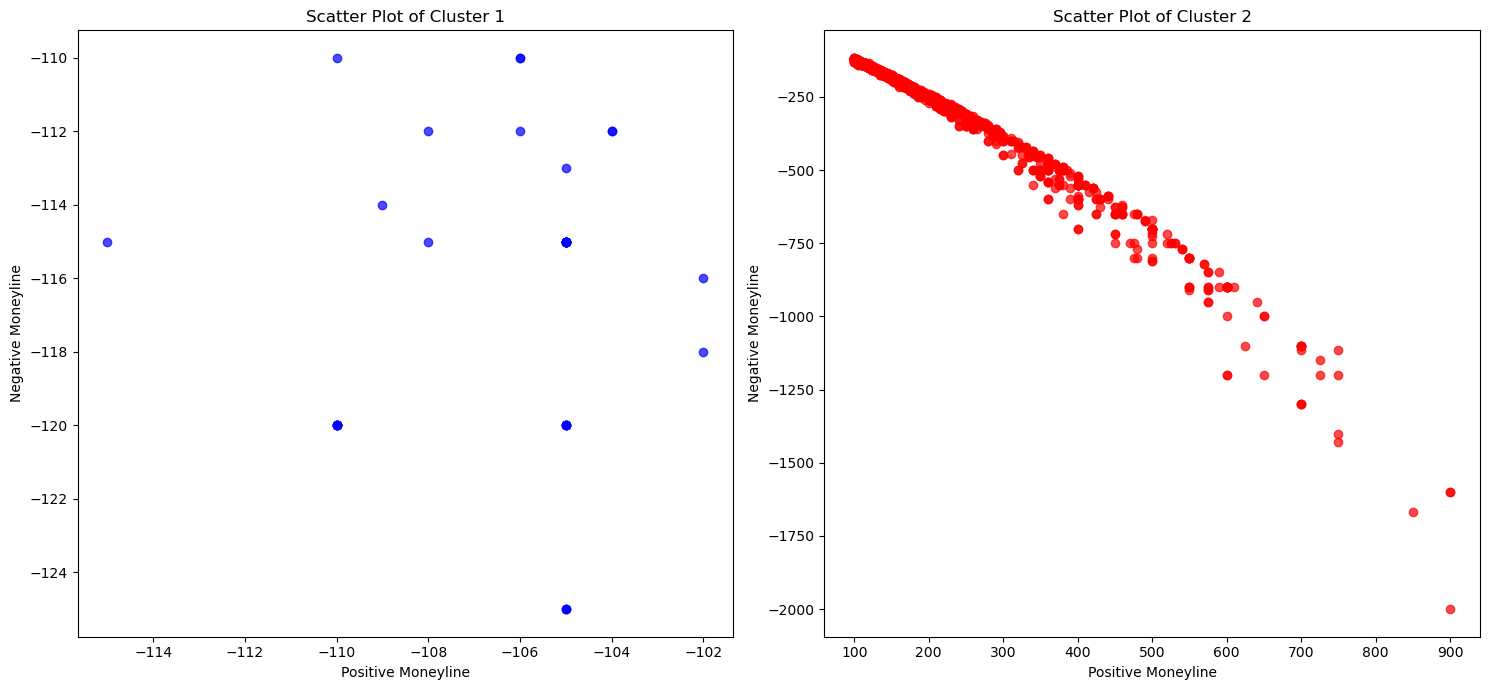

In [169]:
m1 = StatGenModel()
m1.fit(df)
m1.plot_clusters()

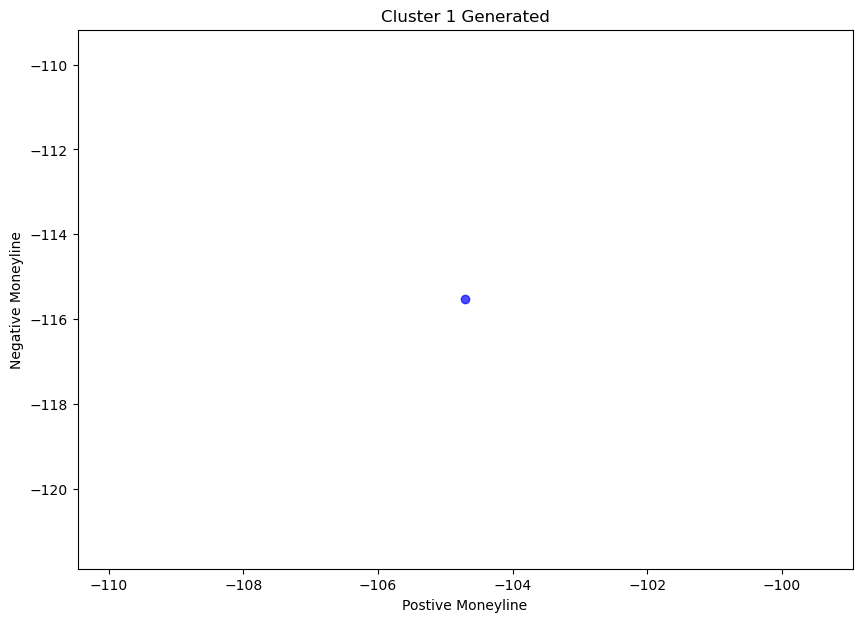

In [170]:
data = m1.generate_c1()
data.shape
plt.figure(figsize=(10, 7))
plt.scatter(data[:, 0], data[:, 1], color='blue', alpha=0.7)
plt.title("Cluster 1 Generated")
plt.xlabel("Postive Moneyline")
plt.ylabel("Negative Moneyline")
plt.show()

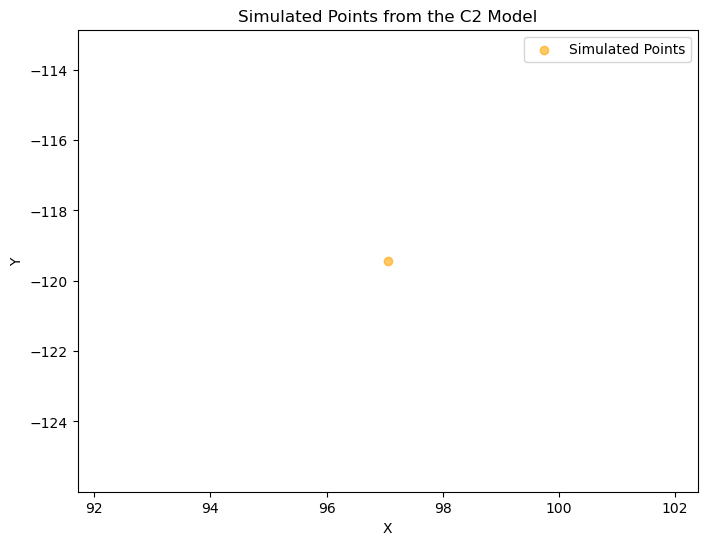

(1, 2)

In [171]:
data = m1.generate_c2()
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1] ,label='Simulated Points', color='orange', alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulated Points from the C2 Model')
plt.legend()
plt.show()
data.shape

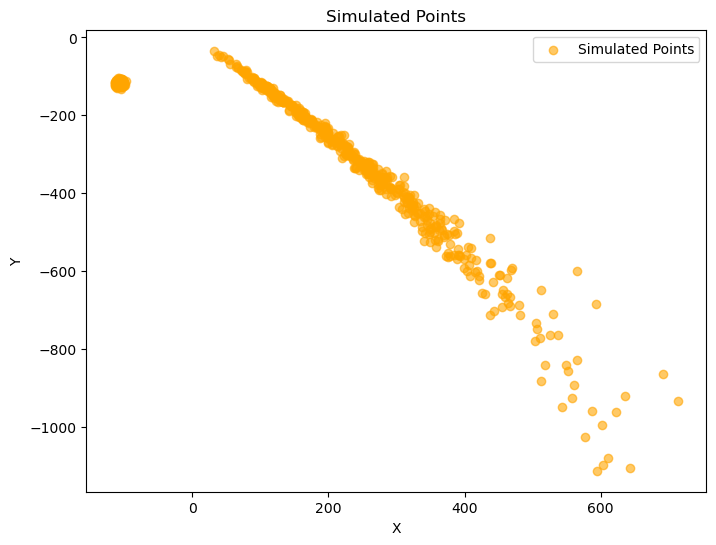

(1000, 2)

In [172]:
data = m1.generate()
plt.figure(figsize=(8, 6))
plt.scatter(data[:, 0], data[:, 1] ,label='Simulated Points', color='orange', alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Simulated Points')
plt.legend()
plt.show()
data.shape

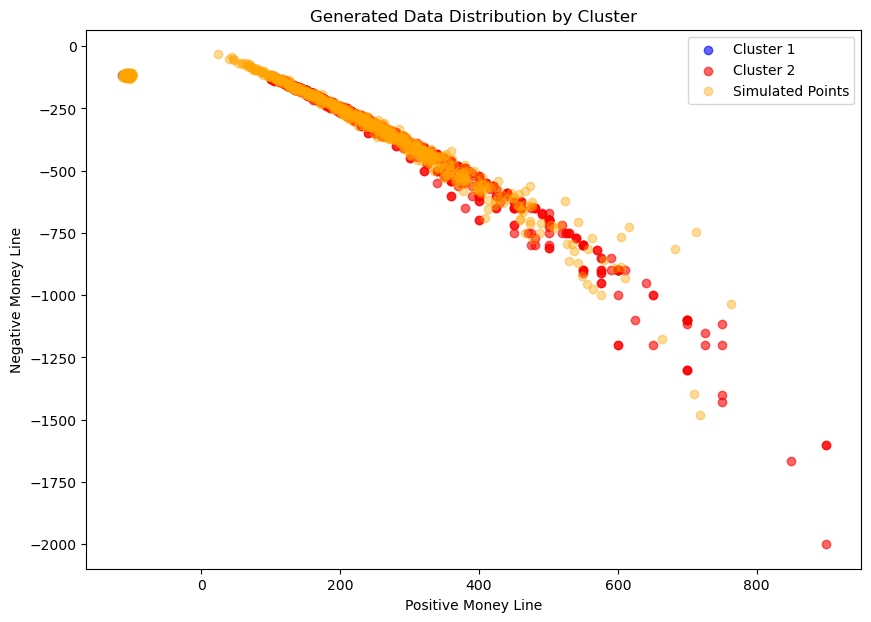

In [173]:
data = m1.generate(1000)


plt.figure(figsize=(10, 7))
for cluster, group in df.groupby('cluster'):
    if cluster == 1:
        color = 'blue'
        label = 'Cluster 1'
    else:
        color = 'red'
        label = 'Cluster 2'
    plt.scatter(group['pos_money'], group['neg_money'], label=label, color=color, alpha=0.6)
plt.scatter(data[:, 0], data[:, 1] ,label='Simulated Points', color='orange', alpha=0.4)
plt.title('Generated Data Distribution by Cluster')
plt.xlabel('Positive Money Line')
plt.ylabel('Negative Money Line')
plt.legend()
plt.show()

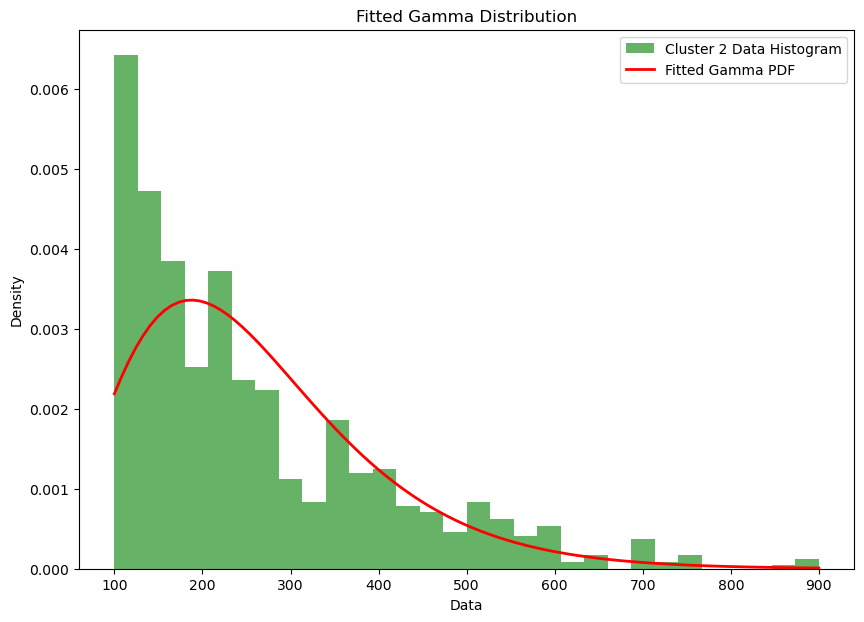

In [174]:
m1.plot_gamma()

### Model 2 Gamma Model for Sampling Pos Money

Estimated shape parameter (k): 3.6538315889519
Estimated scale parameter (theta): 70.60869088040675
3.6538315889519 70.60869088040675


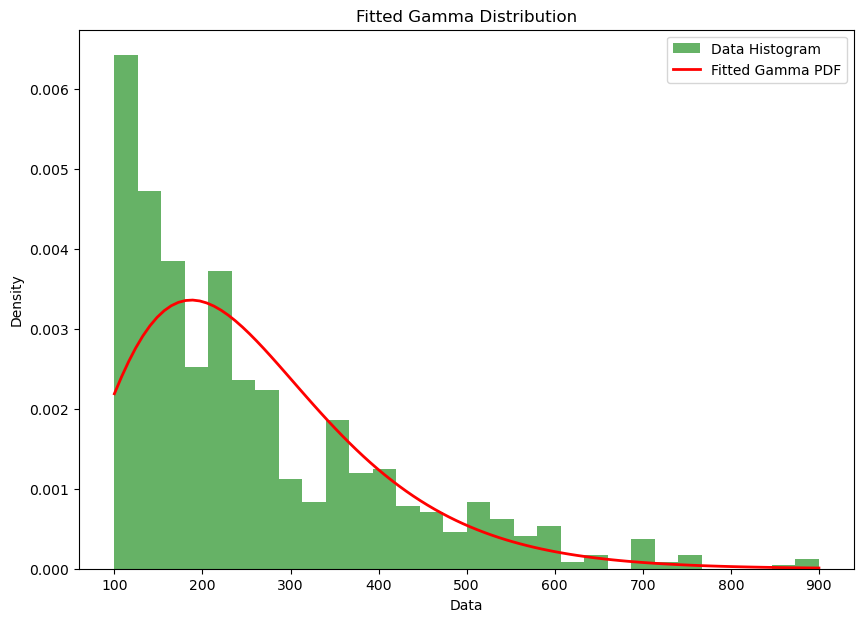

In [175]:
from scipy.optimize import minimize
import scipy.special as sp
from scipy.stats import gamma as gamma_dist

# Assume gamma_data is defined as m1.c2_data[:, 0]
# For example:
gamma_data = m1.c2_data[:, 0]

# Define the negative log-likelihood (NLL) for the Gamma distribution.
def negative_log_likelihood(k, data):
    # k comes as an array from minimize, so extract the scalar.
    k = k[0]
    # Return infinity if k is not positive (to enforce k > 0)
    if k <= 0:
        return np.inf
    
    n = len(data)
    x_bar = np.mean(data)
    # Scale parameter theta is defined as mean(x) / k
    theta = x_bar / k
    
    # Gamma log-likelihood:
    #   L(k,theta) = (k - 1) * sum(log(data)) - sum(data)/theta - n*k*log(theta) - n*log(Gamma(k))
    # Negative log-likelihood (we want to minimize it):
    nll = -((k - 1) * np.sum(np.log(data)) 
            - (np.sum(data) / theta) 
            - n * k * np.log(theta) 
            - n * sp.gammaln(k))
    return nll

def fit_gamma_MLEs(data):
    # Initial guess for k using the method of moments
    k_init_moment = (np.mean(data) ** 2) / np.var(data, ddof=1)
    
    # Optimize the negative log-likelihood
    result = minimize(
        fun=negative_log_likelihood, 
        x0=[k_init_moment], 
        args=(data,), 
        method="L-BFGS-B", 
        bounds=[(0.01, None)]
    )
    
    # Extract the estimated shape parameter k
    k_mle = result.x[0]
    # Compute the scale parameter theta (theta = mean / k)
    theta_mle = np.mean(data) / k_mle
    
    return k_mle, theta_mle

# Fit the Gamma MLE parameters
k_mle, theta_mle = fit_gamma_MLEs(gamma_data)
print("Estimated shape parameter (k):", k_mle)
print("Estimated scale parameter (theta):", theta_mle)

# Plotting: histogram of data with fitted Gamma PDF overlaid.
plt.figure(figsize=(10, 7))

# Plot a histogram of the data with density normalization
count, bins, _ = plt.hist(gamma_data, bins=30, density=True, alpha=0.6, color='g', label='Data Histogram')

# Generate x-values for plotting the gamma PDF
x_values = np.linspace(gamma_data.min(), gamma_data.max(), 100)
pdf_values = gamma_dist.pdf(x_values, a=k_mle, scale=theta_mle)
print(k_mle, theta_mle)

# Overlay the fitted Gamma PDF
plt.plot(x_values, pdf_values, 'r-', lw=2, label='Fitted Gamma PDF')

plt.title("Fitted Gamma Distribution")
plt.xlabel("Data")
plt.ylabel("Density")
plt.legend()
plt.show()


### Model 2 Regression Models

Fitted Polynomial:           2
-0.00102 x - 0.9315 x - 21.68
Polynomial(0): -21.681908461239452


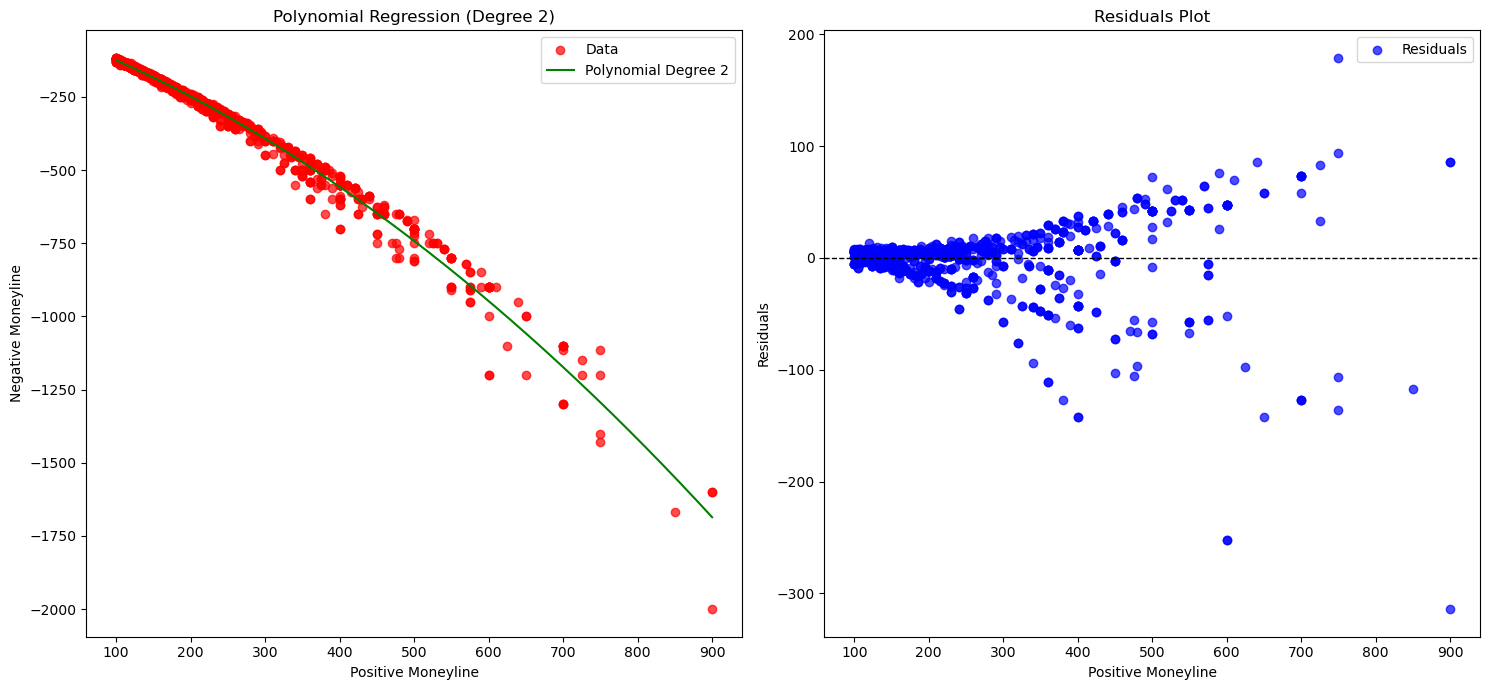

In [176]:
import numpy as np
import matplotlib.pyplot as plt

def plot_polynomial_regression_with_residuals(data, degree):
    """
    Fits a polynomial regression for the given data and plots both the fitted curve and the residuals.
    
    Parameters:
        data (np.ndarray): A 2D array where the first column is X and the second is y.
        degree (int): Degree of the polynomial to fit.
    """
    # Separate the independent (X) and dependent (y) variables
    X = data[:, 0]
    y = data[:, 1]
    
    # Fit a polynomial of the given degree
    coefficients = np.polyfit(X, y, degree)
    polynomial = np.poly1d(coefficients)
    print("Fitted Polynomial:", polynomial)
    print("Polynomial(0):", polynomial(0))
    
    # Generate values for plotting the polynomial curve
    X_line = np.linspace(X.min(), X.max(), 500)
    y_line = polynomial(X_line)
    
    # Compute predictions for the original X values and calculate residuals
    y_pred = polynomial(X)
    residuals = y - y_pred
    
    # Create a figure with 2 subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Left plot: Original data with the fitted polynomial curve
    ax1.scatter(X, y, color='red', alpha=0.7, label='Data')
    ax1.plot(X_line, y_line, color='green', label=f'Polynomial Degree {degree}')
    ax1.set_title(f"Polynomial Regression (Degree {degree})")
    ax1.set_xlabel("Positive Moneyline")
    ax1.set_ylabel("Negative Moneyline")
    ax1.legend()
    
    # Right plot: Residuals
    ax2.scatter(X, residuals, color='blue', alpha=0.7, label='Residuals')
    ax2.axhline(0, color='black', linewidth=1, linestyle='--')
    ax2.set_title("Residuals Plot")
    ax2.set_xlabel("Positive Moneyline")
    ax2.set_ylabel("Residuals")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming m1.c2_data is your data array
plot_polynomial_regression_with_residuals(m1.c2_data, degree=2)


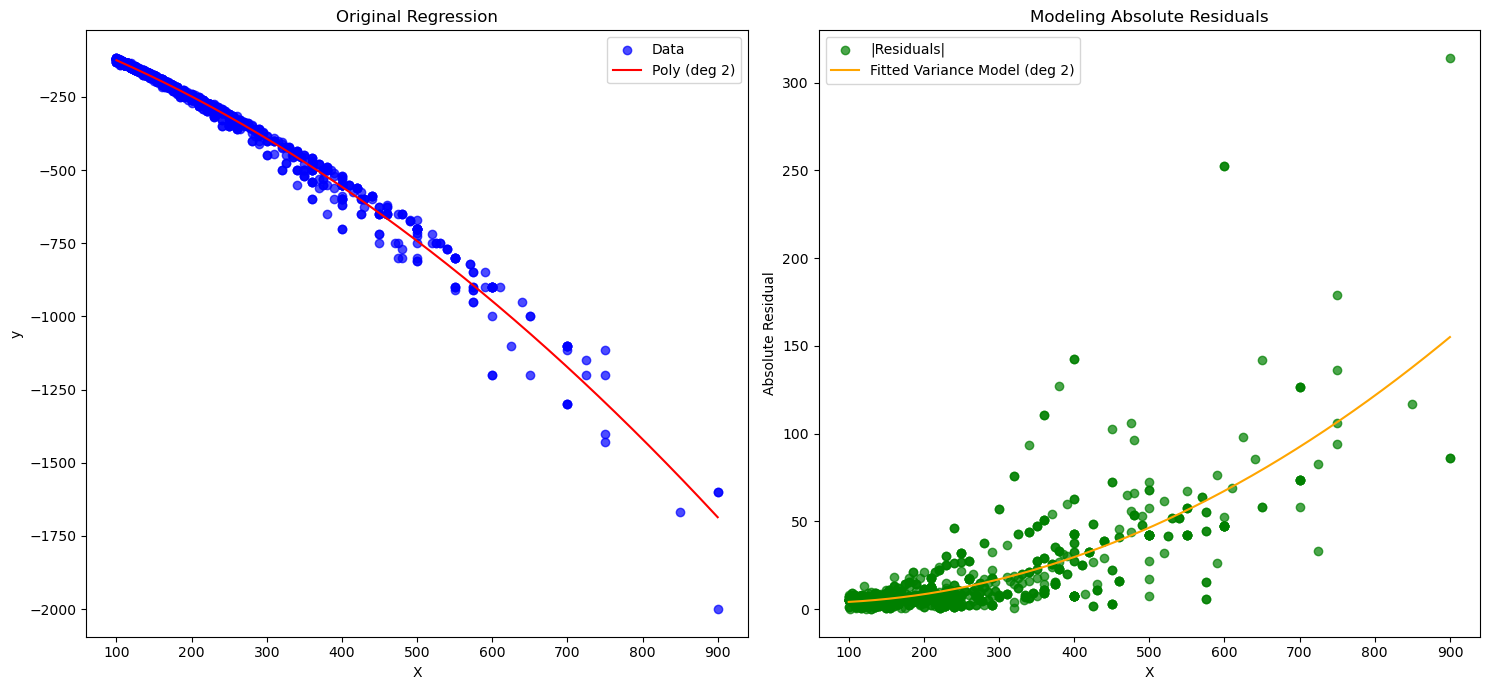

In [177]:
import numpy as np
import matplotlib.pyplot as plt

def fit_and_plot_residual_model(data, degree_model=1, degree_res=2):
    """
    Fits a polynomial regression model to the data, computes residuals,
    and then fits a polynomial to the absolute residuals.
    
    Parameters:
        data (np.ndarray): A 2D array where the first column is X and the second is y.
        degree_model (int): Degree of the polynomial for the primary regression.
        degree_res (int): Degree of the polynomial for modeling absolute residuals.
    """
    # Separate the variables
    X = data[:, 0]
    y = data[:, 1]
    
    # Fit the primary polynomial regression model
    coeffs = np.polyfit(X, y, degree_model)
    poly_model = np.poly1d(coeffs)
    
    # Predictions and residuals
    y_pred = poly_model(X)
    residuals = y - y_pred
    abs_residuals = np.abs(residuals)
    
    # Fit a polynomial to the absolute residuals
    res_coeffs = np.polyfit(X, abs_residuals, degree_res)
    poly_res = np.poly1d(res_coeffs)
    
    # Generate a smooth line for both models
    X_line = np.linspace(X.min(), X.max(), 500)
    y_line = poly_model(X_line)
    abs_res_line = poly_res(X_line)
    
    # Plotting the regression and residuals side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    # Left: Data with fitted regression
    ax1.scatter(X, y, color='blue', alpha=0.7, label='Data')
    ax1.plot(X_line, y_line, color='red', label=f'Poly (deg {degree_model})')
    ax1.set_title("Original Regression")
    ax1.set_xlabel("X")
    ax1.set_ylabel("y")
    ax1.legend()
    
    # Right: Absolute residuals and their fitted model
    ax2.scatter(X, abs_residuals, color='green', alpha=0.7, label='|Residuals|')
    ax2.plot(X_line, abs_res_line, color='orange', label=f'Fitted Variance Model (deg {degree_res})')
    ax2.set_title("Modeling Absolute Residuals")
    ax2.set_xlabel("X")
    ax2.set_ylabel("Absolute Residual")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

# Example usage with your data:
data = m1.c2_data

# Adjust the degrees as needed
fit_and_plot_residual_model(data, degree_model=2, degree_res=2)


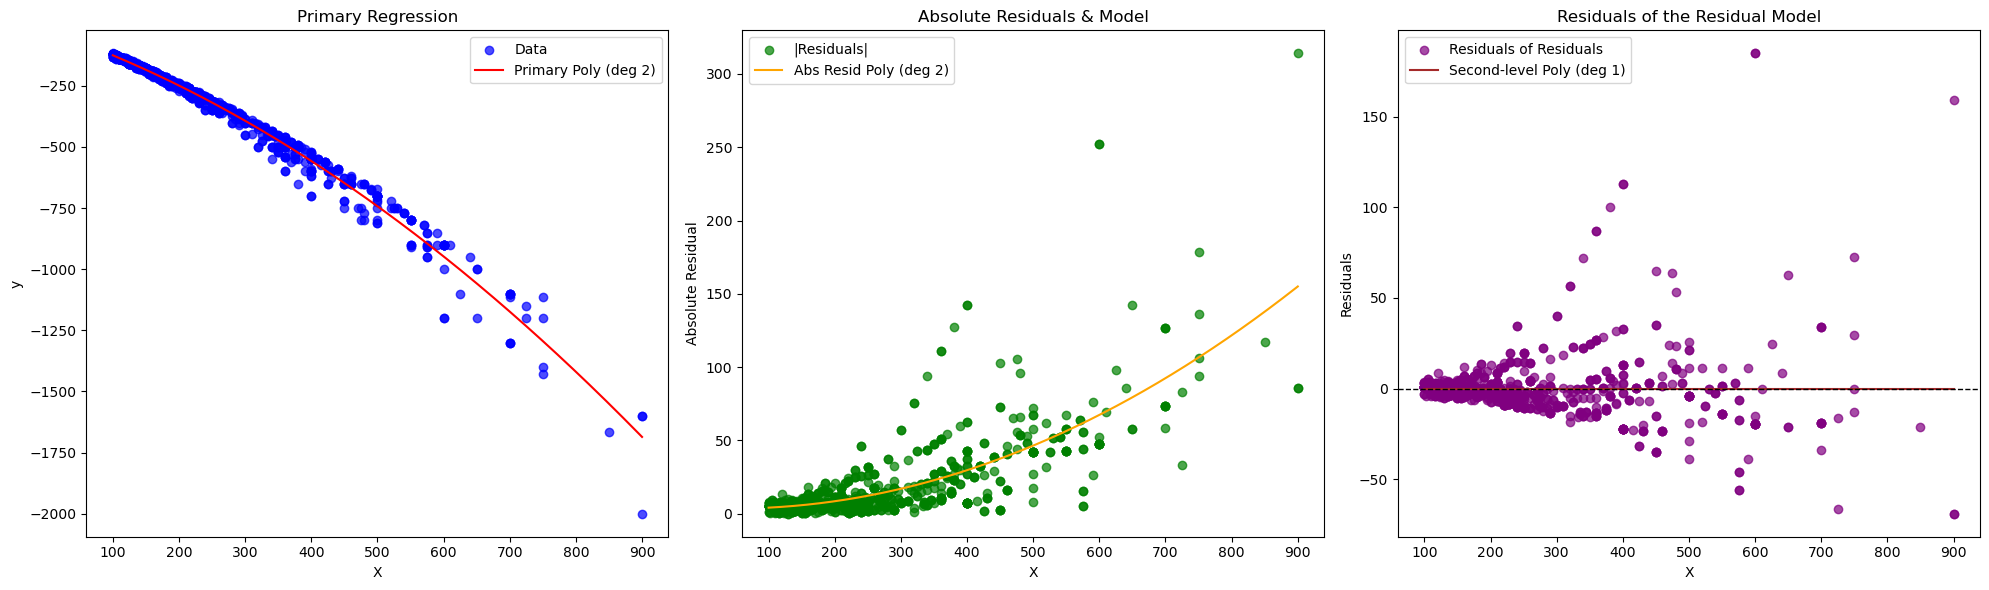

In [178]:
import numpy as np
import matplotlib.pyplot as plt

def fit_double_residual_model(data, degree_model=1, degree_abs_res=2, degree_resid2=1):
    """
    Fits a primary polynomial regression model, then fits a model to the absolute residuals,
    and finally fits a model to the residuals of that absolute residual model.
    
    Parameters:
        data (np.ndarray): 2D array with the first column as X and the second as y.
        degree_model (int): Degree of the polynomial for the primary regression.
        degree_abs_res (int): Degree of the polynomial for modeling the absolute residuals.
        degree_resid2 (int): Degree of the polynomial for modeling the residuals of the residual model.
    """
    # Separate variables
    X = data[:, 0]
    y = data[:, 1]
    
    # --- Primary Regression Model ---
    # Fit a polynomial to the data: y = poly1(X)
    coeffs1 = np.polyfit(X, y, degree_model)
    poly1 = np.poly1d(coeffs1)
    y_pred = poly1(X)
    
    # Compute the primary residuals and their absolute values
    resid = y - y_pred
    abs_resid = np.abs(resid)
    
    # --- Model the Absolute Residuals ---
    # Fit a polynomial to the absolute residuals: |resid| = poly2(X)
    coeffs2 = np.polyfit(X, abs_resid, degree_abs_res)
    poly2 = np.poly1d(coeffs2)
    abs_resid_pred = poly2(X)
    
    # Compute the residuals of this absolute residual model:
    resid2 = abs_resid - abs_resid_pred
    
    # --- Model the Residuals of the Residual Model ---
    # Fit a polynomial to resid2: resid2 = poly3(X)
    coeffs3 = np.polyfit(X, resid2, degree_resid2)
    poly3 = np.poly1d(coeffs3)
    
    # Generate a smooth set of X values for plotting
    X_line = np.linspace(X.min(), X.max(), 500)
    
    # Predictions for smooth lines
    y_line = poly1(X_line)
    abs_res_line = poly2(X_line)
    resid2_line = poly3(X_line)
    
    # --- Plotting ---
    fig, axs = plt.subplots(1, 3, figsize=(20, 6))
    
    # Left subplot: Primary regression fit
    axs[0].scatter(X, y, color='blue', alpha=0.7, label='Data')
    axs[0].plot(X_line, y_line, color='red', label=f'Primary Poly (deg {degree_model})')
    axs[0].set_title("Primary Regression")
    axs[0].set_xlabel("X")
    axs[0].set_ylabel("y")
    axs[0].legend()
    
    # Middle subplot: Absolute residuals and their fitted model
    axs[1].scatter(X, abs_resid, color='green', alpha=0.7, label='|Residuals|')
    axs[1].plot(X_line, abs_res_line, color='orange', label=f'Abs Resid Poly (deg {degree_abs_res})')
    axs[1].set_title("Absolute Residuals & Model")
    axs[1].set_xlabel("X")
    axs[1].set_ylabel("Absolute Residual")
    axs[1].legend()
    
    # Right subplot: Residuals of the absolute residual model and their fitted model
    axs[2].scatter(X, resid2, color='purple', alpha=0.7, label='Residuals of Residuals')
    axs[2].plot(X_line, resid2_line, color='brown', label=f'Second-level Poly (deg {degree_resid2})')
    axs[2].axhline(0, color='black', linestyle='--', linewidth=1)
    axs[2].set_title("Residuals of the Residual Model")
    axs[2].set_xlabel("X")
    axs[2].set_ylabel("Residuals")
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()


fit_double_residual_model(data, degree_model=2, degree_abs_res=2, degree_resid2=1)


## Exponential residual model

In [179]:

# Extract x and y
x = m1.c2_data[:, 0]
y = m1.c2_data[:, 1]

def gaussian_neg_log_likelihood(params, x, y):
    """
    Calculate the negative log likelihood for the model:
      Y | X ~ N( b0 + b1*x + b2*x^2, exp(alpha0 + alpha1*x) )
    
    Parameters:
      params : array-like, [b0, b1, b2, alpha0, alpha1]
      x      : predictor values (numpy array)
      y      : response values (numpy array)
      
    Returns:
      nll : negative log likelihood value (float)
    """
    b0, b1, b2, alpha0, alpha1 = params
    # Mean function: mu = b0 + b1*x + b2*x^2
    mu = b0 + b1 * x + b2 * x**2
    # Variance function: sigma^2 = exp(alpha0 + alpha1*x)
    sigma2 = np.exp(alpha0 + alpha1 * x)
    # Calculate the negative log likelihood
    nll = 0.5 * np.sum(np.log(2 * np.pi) + (alpha0 + alpha1 * x) + ((y - mu)**2) / sigma2)
    return nll

# Initial guess for parameters [b0, b1, b2, alpha0, alpha1]
init_params = np.array([0.0, 0.0, 0.0, 0.0, 0.0])

# Minimize the negative log likelihood using scipy.optimize.minimize
result = minimize(gaussian_neg_log_likelihood, init_params, args=(x, y), method='L-BFGS-B')

if result.success:
    est_params = result.x
    print("Estimated parameters:")
    print("b0     =", est_params[0])
    print("b1     =", est_params[1])
    print("b2     =", est_params[2])
    print("alpha0 =", est_params[3])
    print("alpha1 =", est_params[4])
    print("\nMinimum negative log likelihood:", result.fun)
else:
    print("Optimization failed:", result.message)

# )


Estimated parameters:
b0     = -0.05376022216824724
b1     = -1.129351301894249
b2     = -0.0006477692623368938
alpha0 = 2.0729231883140904
alpha1 = 0.01258202015677937

Minimum negative log likelihood: 3690.8996268048077


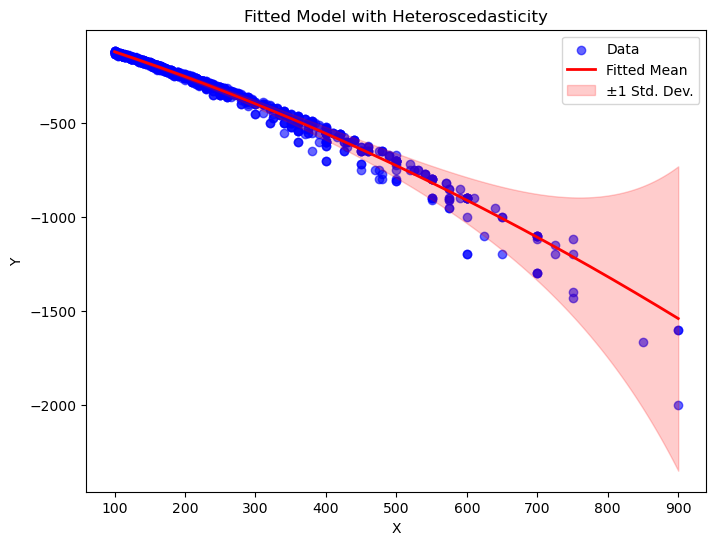

In [180]:
b0, b1, b2 = est_params[0], est_params[1], est_params[2]   # Replace with your estimates for b0, b1, b2
alpha0, alpha1 = est_params[3], est_params[4]      # Replace with your estimates for alpha0, alpha1
# Create a grid of x values for plotting the fitted curve
x_grid = np.linspace(np.min(x), np.max(x), 300)
# Calculate the mean predictions using the quadratic model
mu_grid = b0 + b1 * x_grid + b2 * x_grid**2
# Calculate the standard deviation predictions
sigma_grid = np.sqrt(np.exp(alpha0 + alpha1 * x_grid))

# Create the plot
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Data', color='blue', alpha=0.6)
plt.plot(x_grid, mu_grid, label='Fitted Mean', color='red', linewidth=2)
# Shade the region within one standard deviation
plt.fill_between(x_grid, mu_grid - sigma_grid, mu_grid + sigma_grid,
                 color='red', alpha=0.2, label='±1 Std. Dev.')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Fitted Model with Heteroscedasticity')
plt.legend()
plt.show()

In [181]:
k_mle

3.6538315889519

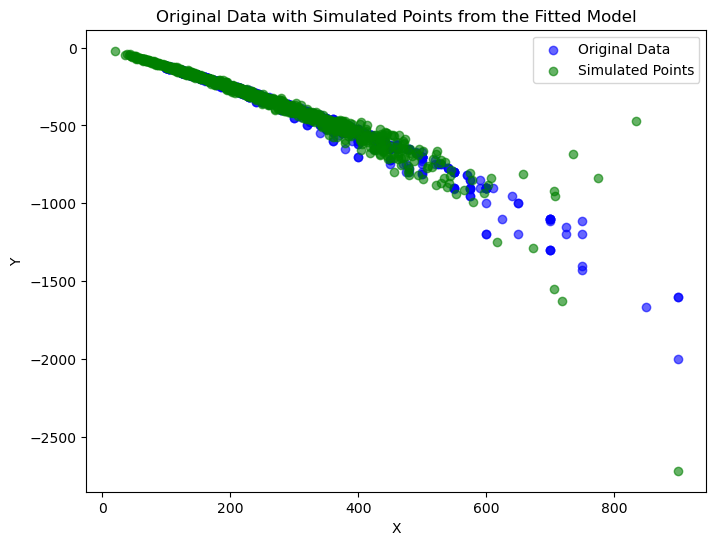

In [182]:
# Generate a grid of x values (same range as your data)
x_sim = np.random.gamma(k_mle, theta_mle, 1000)

# Calculate the mean and standard deviation for the simulated points
mu_sim = b0 + b1 * x_sim + b2 * x_sim**2
sigma_sim = np.sqrt(np.exp(alpha0 + alpha1 * x_sim))

# Generate simulated y values from the normal distribution defined by the model
y_sim = np.random.normal(loc=mu_sim, scale=sigma_sim)

# Create the plot:
plt.figure(figsize=(8, 6))
plt.scatter(x, y, label='Original Data', color='blue', alpha=0.6)
plt.scatter(x_sim, y_sim, label='Simulated Points', color='green', alpha=0.6)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Original Data with Simulated Points from the Fitted Model')
plt.legend()
plt.show()